# COGS 108 - Final Project 

# Overview

In this project, I intended to identify a correlation between the type of park and visitor satisfaction towards the park. I looked at the dataset of yelp reviews towards parks and their park type classified by the Parks & Recreation department. From this analysis, I was unable to definitively conclude whether any correlation would exist, likely due to small sample sizes within national and state parks in San Diego. The data seems to suggest that more research and surveys would be needed to improve the quality of data, but also that local parks are well-received and still has the room for some improvement.

# Name & GitHub

- Name: Juhmer Tena
- GitHub Username: Axios Deminence

# Research Question

Is there a relationship between the type of park (e.g., Historic, National, State) and visitor satisfaction towards the park?

## Background and Prior Work

According to the first source, park satisfaction varies depending on "place attachment." Much like the support for local businesses, it may be possible that people are more satisfied and intend to revisit the park. This is relevant to our research question as we attempt to quantify the satisfaction based on the park type.

According to the second source, park satisfaction also varies depending on the maintenance and personnel which manages the park. This is relevant to our research question, since parks managed by state or national authorities would have more resources than the county.

References (include links):
- 1) https://www.researchgate.net/publication/339619138_The_Relationship_Between_Park_Satisfaction_Place_Attachment_and_Revisit_Intention_in_Neighborhood_Parks_with_Physical_Activity_Facilities
- 2) http://staff.washington.edu/kwolf/Archive/Classes/ESRM304_SocSci/304%20Soc%20Sci%20Lab%20Articles/Fletcher_2003.pdf

# Hypothesis


I hypothesize that parks managed by a higher level of government will have higher yelp ratings because of their access to more resources. Parks managed by these higher levels of government will be able to improve the facilities and maintenance of those facilities due to more funding which would lead towards better park visitor satisfaction. On the other end, we'd likely see more negative yelp ratings towards parks managed by more local levels of government. 

# Dataset(s)

I plan to use the following datasets to sort through the different parks within San Diego. I use the yelp_SD_parks for the list of parks that can have their visitor satisfaction predicted through yelp ratings (which are found in yelp_SD_reviews). I also use the parks_datasd to find the type of parks. 

- Dataset Name: yelp_SD_parks
- Link to the dataset: Dataset provided
- Number of observations: 833
- Description: The parks within San Diego that have yelp ratings. Each observation is a park with their name, address, phone number, id, url to the yelp page, average yelp rating, number of yelp reviews, geolocational data, and the status if the park is closed.


- Dataset Name: yelp_SD_reviews
- Link to the dataset: Dataset provided
- Number of observations: 2333
- Description: Yelp within San Diego. Each observation is one review with the facility that is being rated, the quantified rating given, and the rating's text.


- Dataset Name: parks_datasd
- Link to the dataset: Dataset provided
- Number of observations: 2769
- Description: The parks within San Diego. Each observation is a park with their unique ID, the short park name, the park alias, the size of the park calculated from polygons, the park type, the geolocational and string-representation of the park's location location, and the owner of the park.

# Setup

In [1]:
#!pip install geopandas

In [23]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
sns.set_context('talk')
sns.set_style("white")

import geopandas as gpd

import patsy
import statsmodels.api as sm

# Data Cleaning

Remove columns and merge datasets into dataframes

In [3]:
yelp_parks = pd.read_csv("../data/yelp_SD_parks.csv")
yelp_reviews = pd.read_csv("../data/yelp_SD_reviews.csv")
park_data = gpd.read_file("../data/parks_datasd.geojson")
park_data = pd.DataFrame(park_data)

## Cutting down data

To make the dataset more managable, I removed any unnecessary columns which I would not utilize while analyzing the differences between the different park_types.

In [4]:
yelp_parks = yelp_parks.drop(["address", "phone", "id", "url", "rating", "longitude", "latitude", "is_closed", "review_count"], axis=1)
yelp_reviews = yelp_reviews.drop(["text"], axis=1)
park_data = park_data.drop(["geometry", "objectid", "gis_acres", "location"], axis=1)

## Cleaning data

While looking at the data, I noticed that some names and aliases were inconsistently formatted within the park_data dataframe (e.g., Balboa Park's name was in all uppercase). I also noticed that I could not determine the park type by looking at the owner (since some owners both regional and local parks). As such, I changed the names and aliases of the parks to be lowercase in every dataframe and drop the owner column from park_data. Due to the ambiguous nature of which level of government manages parks not classified as "Local", "Regional", "State", or "National", I removed parks without these classifications.

In [5]:
yelp_reviews["id"] = yelp_reviews["id"].str.lower()
yelp_parks["name"] = yelp_parks["name"].str.lower()
park_data["name"] = park_data["name"].str.lower()
park_data["alias"] = park_data["alias"].str.lower()
park_data["park_type"] = park_data["park_type"].str.lower()

park_data = park_data.drop(["owner"], axis=1)

park_data = park_data[park_data["park_type"].isin(["local", "regional", "state", "national"])]

## More cleaning data (before merging dataframes)

At this point, I realized a crucial error within these datasets. Many aliases and names within the park_data is identical to another. I experimented with trying to spatially join these sets (since we have known longitude and latitude coordinates for the parks from yelp), but I ran into errors that I found out could not be solved by using datahub or jupyter notebooks on my own system. As such, I dediced to drop all rows that have identical aliases. I also found out that after merging dataframes, merging it through the "alias" column would result in a greater sample size and renamed and dropped columns as necessary.

In [6]:
park_data = park_data.groupby("alias").filter(lambda x: len(x)==1)
park_data = park_data.drop(["name"], axis=1)

yelp_parks = yelp_parks.rename(columns={"name": "alias"})

yelp_reviews = yelp_reviews.rename(columns={"id": "alias"})

## Merging Dataframes (finally)

At this point, we can finally merge the dataframes based on the aliases. We no longer need the aliases as we now have ratings with the park_type associated, so we drop the alias column after merging.

In [7]:
yelp_parks_w_types = yelp_parks.merge(park_data, how="inner", on="alias")

yelp_reviews = yelp_reviews.merge(yelp_parks_w_types, how="inner", on="alias")
yelp_reviews = yelp_reviews.drop(["alias"], axis=1)

# Data Analysis & Results

## Number of parks with Yelp Reviews with known park type

Text(0.5, 1.0, 'Number of parks categorized by park types')

<Figure size 864x576 with 0 Axes>

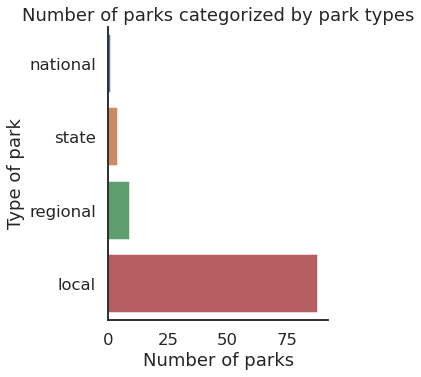

In [10]:
plt.figure(figsize=(12,8))
park_type_dist = sns.catplot(data=yelp_parks_w_types, kind="count", y="park_type", order=["national", "state", "regional", "local"])
plt.xlabel("Number of parks")
plt.ylabel("Type of park")
plt.title("Number of parks categorized by park types")

# sns.catplot(data=yelp_parks)

# sns.catplot(data=yelp_reviews, kind="count", x="park_type", order=["national", "state", "regional", "local"])
# sns.catplot(data=yelp_reviews, kind="box", x="park_type", y="rating")

# plt.gcf()

By and large, it appears that the majority of parks within San Diego are considered to be local parks. This is important mainly for the next data visualizations as it will be important to keep in mind that our sample size with non-local parks are smaller in number.

## Satisfaction of parks categorized by park types

Text(0.5, 1.0, 'Park ratings categorized by park types')

<Figure size 864x576 with 0 Axes>

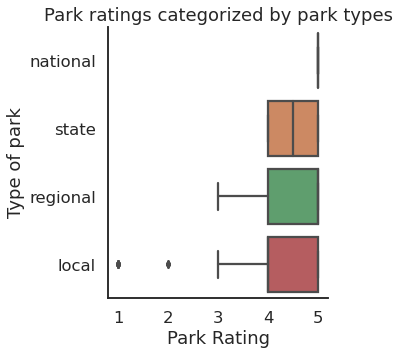

In [22]:
plt.figure(figsize=(12,8))
park_type_dist = sns.catplot(data=yelp_reviews, kind="box", y="park_type", x="rating", order=["national", "state", "regional", "local"])
plt.xticks(ticks=[1,2,3,4,5])
plt.xlabel("Park Rating")
plt.ylabel("Type of park")
plt.title("Park ratings categorized by park types")

At first glance, it appears that overall satisfaction of parks decrease as the classification of park becomes more local (e.g., state is more local than national). This glance value fits in with our hypothesis that local parks have less visitor satisfaction, likely because of a comparative lack of funding at the local level.

## Linear regression to find relationship between park types and satisfaction

In [26]:
outcome, predictors = patsy.dmatrices("rating ~ park_type", yelp_reviews)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     3.853
Date:                Mon, 14 Dec 2020   Prob (F-statistic):            0.00986
Time:                        02:23:57   Log-Likelihood:                -467.59
No. Observations:                 325   AIC:                             943.2
Df Residuals:                     321   BIC:                             958.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 4.08

The linear regression model shown above does not appear to be a good model to predict the differences in rating between the different park types. This is also the case when taking note of the "national" and "state" park types which have a high probability of not being a statistically significant predictor. However, this result may be due to the small sample size of national and state parks since "regional" parks appear to remain a good predictor.

## How do local parks fare?

Text(0.5, 1.0, 'Ratings of local parks')

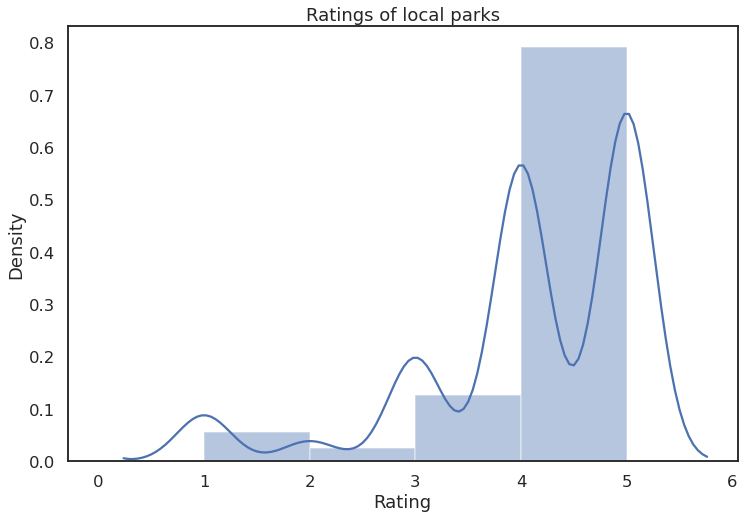

In [71]:
plt.figure(figsize=(12,8))
yelp_reviews[yelp_reviews["park_type"] == "local"]["rating"]
something = sns.distplot(a=yelp_reviews[yelp_reviews["park_type"] == "local"]["rating"], bins=np.arange(0,6))
plt.xlabel("Rating")
plt.ylabel("Density")
plt.title("Ratings of local parks")

While it may be that parks considered to more local fare worse compared to its regional, state, and national counterparts, it is evident that most people are satisfied with their local parks. With any data, there are outliers and these outliers were accounted for when observing the boxplot. As such, local parks may be rated less satisfactory than its counterparts but is by no means unsatisfactory in the eyes of many.

# Ethics & Privacy

This dataset was provided to us for the final project.

Privacy concerns with the datasets used mainly deal with phone numbers of park owners in yelp and possible text corresponding to yelp reviews. These data points are removed and are irrelevant to the data analysis.

One bias within the datasets used is the collection of data of yelp reviews which would prevent those without internet access from being accounted in this study. It can also be biased because of inconsistent naming between Yelp and internal San Diego Parks & Recreation tracking of parks which ultimately resulted in the removal of potential data points.

One possible consequence of this data may be the reduction of funding towards the maintenace of local parks as they perform worse than state, regional, and national parks. However, something that must be noted is that most parks within San Diego are considered local parks and that they remain satisfactory because of their maintenance. 

These issues can be solved through further research and surveys for park visitors and residents living near parks about their perspective on the parks. A study that correctly documents the different parks and the satisfaction of park visitors will be much more accurate than sourcing the data from services such as Yelp. This may result in more datapoints and will even be able to generate more data that can prove useful in understanding which parks may need improvement and extra funding for said improvement.

# Conclusion & Discussion

In this project, I intended to find a correlation between satisfaction between local, regional, state, and national parks. I used yelp reviews and ratings as my basis of park visitor satisfaction for every park. I used information from the Parks & Recreation department in order to classify parks into either local, regional, state, and national parks. I merged these datasets and created a linear regression model to understand the correlation between different park types and yelp ratings. The linear regression model appeared to suggest that state and national parks have little correlation to the ratings (likely due to their small sample size within San Diego). However, local parks also largely experience park visitor satisfaction. Based on these results, I was unable to definitively conclude the presence or absence of a correlation between park types and park visitor satisfaction due to the small sample size. This means that I must reject my hypothesis.

The most severe limitations to this project were the datasets that I were provided. In order to use yelp reviews and classify parks on yelp as local, regional, state, and national parks, I had to sacrifice many potential datapoints. I also observed that some park names differed between datasets, however I found no procedural way to solve this issue. There was also a limited understanding of the different park types. I removed "Open space" and "historic" park types from the datasets used as there was no way to tell which level of government took jurisdiction over the maintenance of those parks. Another limitation to this project was that it can only be applied to the San Diego area.

This project can help provide the knowledge that local parks can still use improvement which can aid community well-being. This project also serves as a basis of the need for more research required before taking action, likely in the form of park visitor surveys and more internal tracking of park visitor satisfaction and usage.